In [7]:
from consistency import *
from MDS_analysis import *
from rcv_distribution import *

In [59]:
csv =  "dataverse_files/Alaska_08162022_HouseofRepresentativesSpecial.csv"
ballots, candidates = parse_election_data(csv)
print(candidates)

# Perform the RCV analysis
test = perform_rcv_analysis(ballots, candidates, 1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
print("Normalized distances:", normalized_distances)

['Peltola, Mary S.', 'Begich, Nick', 'Palin, Sarah']


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\cleaned files\MDS_analysis.py:162: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Palin, Sarah': 0.0, 'Begich, Nick': 0.8406278753516899, 'Peltola, Mary S.': 2.0}


In [60]:
from scipy.optimize import linprog

def solve_lp(b_num, n):
    obj = [1]
    lhs_ineq = []
    rhs_ineq = []
    e = 0.000000001
    
    for i in range(len(b_num)):
        for j in range(i + 1, len(b_num)):
            mid = (b_num[i] + b_num[j]) / 2
            if b_num[i] > b_num[j]:
                lhs_ineq.append([-1])
                rhs_ineq.append(-(e + mid))
            if b_num[i] < b_num[j]:
                lhs_ineq.append([1])
                rhs_ineq.append(e + mid)
    
    # Bounds for the variable x
    bnd = [(0, n - 1)]
    
    # Solve for the minimum value
    opt_min = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method="revised simplex")
    
    # Solve for the maximum value
    opt_max = linprog(c=[-c for c in obj], A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method="revised simplex")
    
    if opt_min.success and opt_max.success:
        min_value = opt_min.fun
        max_value = -opt_max.fun  # Negate because we minimized the negative of the objective
        interval = (min_value, max_value)
        return True, interval
    else:
        return False, None

In [61]:
def distribute_points(interval, num_points=1000):
    min_val, max_val = interval
    return np.linspace(min_val, max_val, num_points)

In [62]:
distributed_points = []
    
for b in ballots:
    if len(b) > 0:
        b_num = ballot_to_num(b, normalized_distances)
        if len(b) > 1:    
            success, interval = solve_lp(b_num, len(candidates))
            if success:
                points = distribute_points(interval, ballots[b])
                distributed_points.extend(points)
        else:
            success = True
            interval = (b_num, b_num)
            points = distribute_points(interval, ballots[b])
            distributed_points.extend(points)


C:\Users\mahsh\AppData\Local\Temp\ipykernel_21972\2268269555.py:1: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  distributed_points = np.array(distributed_points, dtype=float)


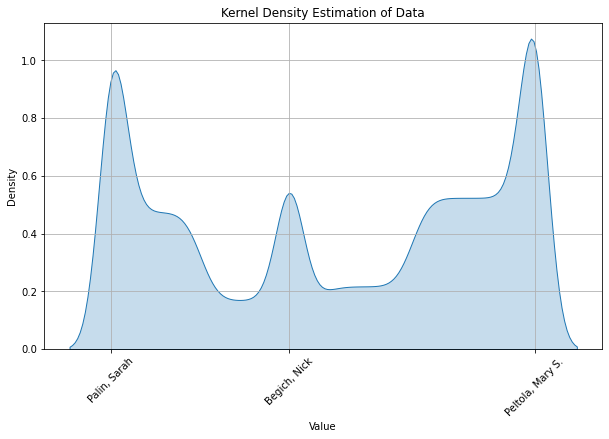

In [63]:
distributed_points = np.array(distributed_points, dtype=float)
normalized_points = []
normalized_names = []
for name in normalized_distances:
    normalized_names.append(name)
    normalized_points.append(normalized_distances[name])
plt.figure(figsize=(10, 6))
sns.kdeplot(distributed_points, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [10]:
for b in ballots:
    print(b, " ", ballot_to_num(b, normalized_distances), " ", ballots[b])

('REP Poliquin, Bruce',)   [0.0]   89669
('DEM Golden, Jared F.', 'Bond, Tiffany L.')   [3.0, 2.045219779750644]   10505
('REP Poliquin, Bruce', 'DEM Golden, Jared F.', 'Bond, Tiffany L.', 'Hoar, William R.S.')   [0.0, 3.0, 2.045219779750644, 1.2374621402754458]   3467
('Hoar, William R.S.', 'REP Poliquin, Bruce', 'Bond, Tiffany L.', 'DEM Golden, Jared F.')   [1.2374621402754458, 0.0, 2.045219779750644, 3.0]   306
()   []   5928
('DEM Golden, Jared F.', 'Bond, Tiffany L.', 'Hoar, William R.S.', 'REP Poliquin, Bruce')   [3.0, 2.045219779750644, 1.2374621402754458, 0.0]   23140
('REP Poliquin, Bruce', 'Hoar, William R.S.', 'Bond, Tiffany L.', 'DEM Golden, Jared F.')   [0.0, 1.2374621402754458, 2.045219779750644, 3.0]   11600
('Hoar, William R.S.', 'Bond, Tiffany L.', 'REP Poliquin, Bruce', 'DEM Golden, Jared F.')   [1.2374621402754458, 2.045219779750644, 0.0, 3.0]   579
('DEM Golden, Jared F.',)   [3.0]   51673
('Hoar, William R.S.', 'REP Poliquin, Bruce', 'DEM Golden, Jared F.', 'Bond, 

In [27]:
solve_lp( [2.045219779750644, 0.0, 3.0, 1.2374621402754458], len(candidates))

No solution found


False

In [3]:
gamma_per = consistency.get_interval_consistent_ballots(ballots, normalized_distances)[1]
gamma_strict = consistency.get_strict_gamma(ballots, candidates, normalized_distances)
print(gamma_per)
print(gamma_strict)

0.8437871576328024
0.8033906716893734


In [10]:
normalized_distances = {'REP Poliquin, Bruce': 0.0, 'Hoar, William R.S.': 2, 'DEM Golden, Jared F.' : 1, 'Bond, Tiffany L.': 3.0}
gamma_per = consistency.get_interval_consistent_ballots(ballots, normalized_distances)[1]
gamma_strict = consistency.get_strict_gamma(ballots, candidates, normalized_distances)
print(gamma_per)
print(gamma_strict)

0.7182516569073132
0.6296661370537207
